In [1]:
import os, sys
sys.path.append("yamnet/")

In [4]:
import numpy as np
from librosa.core import load
import soundfile as sf
import IPython.display as ipd

import matplotlib.pyplot as plt

import params
from tools import *
import yamnet as yamnet_model
import tensorflow.compat.v1 as tf

In [5]:
# Read in the audio.
# You can get this example waveform via:
# curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

wav_file_name = 'music/Stranger Things (Extended).mp3'
# wav_file_name = 'speech_whistling2.wav'

# wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
wav_data, sr = load(wav_file_name)
waveform = wav_data
# The graph is designed for a sampling rate of 16 kHz, but higher rates 
# should work too.
params.SAMPLE_RATE = sr
print("Sample rate =", params.SAMPLE_RATE)

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Sample rate = 22050


In [ ]:
ipd.Audio(wav_data.T, rate=sr)

In [6]:
class_names = yamnet_model.class_names('yamnet/yamnet_class_map.csv')
params.PATCH_HOP_SECONDS = 0.1  # 10 Hz scores frame rate.
graph = tf.Graph()
with graph.as_default():
    yamnet = yamnet_model.yamnet_frames_model(params)
    yamnet.load_weights('yamnet/yamnet.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
# Run the model.
with graph.as_default():
    scores, spectrogram = yamnet.predict(np.reshape(waveform, [1, -1]), steps=1)

In [8]:
spectrogram.shape

(32644, 64)

NameError: name 'waveform' is not defined

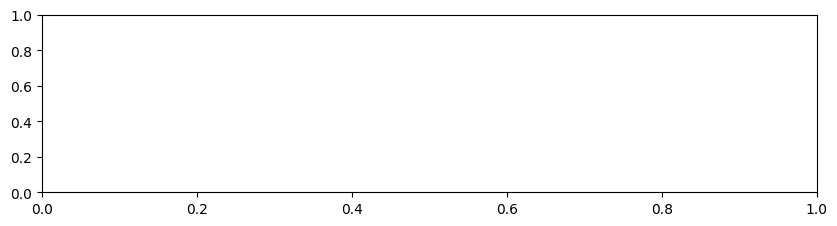

In [9]:
draw_result(waveform, scores, spectrogram)

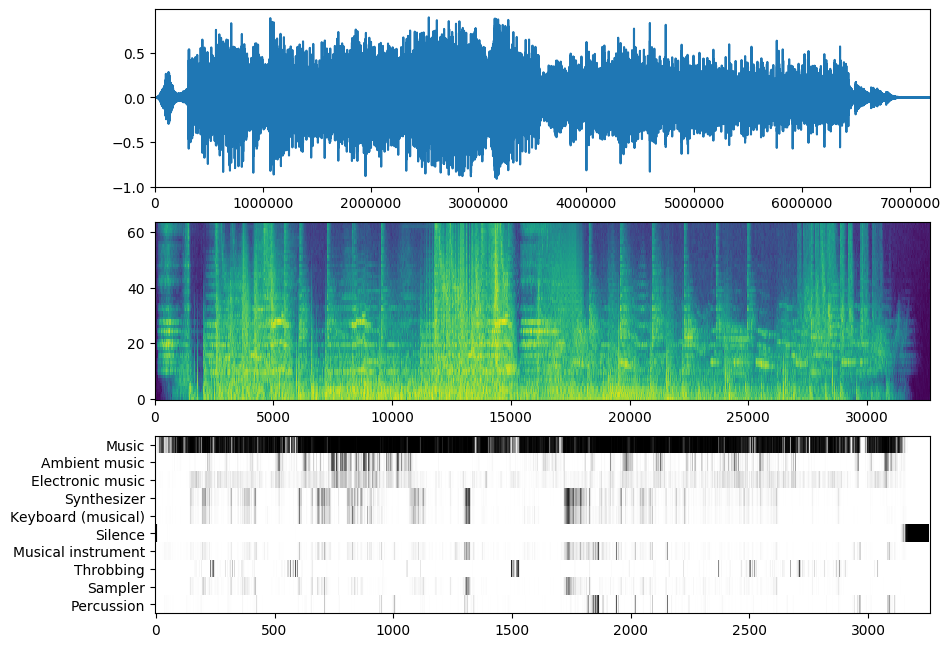

In [61]:
# Visualize the results.
plt.figure(figsize=(10, 8), dpi=100)

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the PATCH_WINDOW_SECONDS (0.96 s) context window to align with spectrogram.
patch_padding = (params.PATCH_WINDOW_SECONDS / 2) / params.PATCH_HOP_SECONDS
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))